In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer,wordnet
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import keras
from keras import layers
from sklearn import metrics
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
# Run in case warnings should be ignored
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth',300)


In [2]:
# get data from txt-file
'''Wiki_article_ID
Freebase_ID
Book_title
Author
Publication_date
Book_genres (Freebase ID:name tuples)
Plot_summary'''
df01 = pd.read_csv('booksummaries.txt', sep="\t", header=None)
df01.columns = ['Wiki_article_ID', 'Freebase_ID', 'Book_title', 'Author','Publication_date','Book_genres','Plot_summary']


In [3]:
df01.head(3)

,Wiki_article_ID,Freebase_ID,Book_title,Author,Publication_date,Book_genres,Plot_summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"": ""Satire"", ""/m/0dwly"": ""Children's literature"", ""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf"": ""Fiction""}","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""Novella"", ""/m/014dfn"": ""Speculative fiction"", ""/m/0c082"": ""Utopian and dystopian fiction"", ""/m/06nbt"": ""Satire"", ""/m/02xlf"": ""Fiction""}","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fiction"", ""/m/0pym5"": ""Absurdist fiction"", ""/m/05hgj"": ""Novel""}","The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."


In [4]:
df01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Wiki_article_ID   16559 non-null  int64 
 1   Freebase_ID       16559 non-null  object
 2   Book_title        16559 non-null  object
 3   Author            14177 non-null  object
 4   Publication_date  10949 non-null  object
 5   Book_genres       12841 non-null  object
 6   Plot_summary      16559 non-null  object
dtypes: int64(1), object(6)
memory usage: 905.7+ KB


In [5]:
df01.isnull().sum()

Wiki_article_ID        0
Freebase_ID            0
Book_title             0
Author              2382
Publication_date    5610
Book_genres         3718
Plot_summary           0
dtype: int64

In [6]:
# delete all the rows where 'Plot_summary' and 'Book_genres' are NaN
df01 = df01.dropna(subset=['Book_genres','Plot_summary'])

In [7]:
df01.isnull().sum()

Wiki_article_ID        0
Freebase_ID            0
Book_title             0
Author               786
Publication_date    3170
Book_genres            0
Plot_summary           0
dtype: int64

In [8]:
# convert 'Book_genres' from json format to list format
df01['Book_genres'] = df01['Book_genres'].map(lambda Book_genres : list(json.loads(Book_genres).values()))

In [9]:
df01['Book_genres'].value_counts()

Book_genres
[Novel]                                                                        839
[Science Fiction, Speculative fiction]                                         567
[Science Fiction]                                                              526
[Fiction]                                                                      402
[Fiction, Novel]                                                               381
                                                                              ... 
[Science Fiction, Speculative fiction, Mystery, Fantasy, Fiction, Suspense]      1
[Speculative fiction, Fantasy, Fiction, Literary fiction]                        1
[Fiction, Graphic novel, Anti-nuclear]                                           1
[Thriller, Spy fiction, Adventure novel]                                         1
[Epistolary novel, Speculative fiction]                                          1
Name: count, Length: 2154, dtype: int64

In [10]:
df01.Book_genres.values

array([list(['Roman à clef', 'Satire', "Children's literature", 'Speculative fiction', 'Fiction']),
       list(['Science Fiction', 'Novella', 'Speculative fiction', 'Utopian and dystopian fiction', 'Satire', 'Fiction']),
       list(['Existentialism', 'Fiction', 'Absurdist fiction', 'Novel']),
       ..., list(['Thriller', 'Fiction']), list(['Autobiography']),
       list(['Epistolary novel', 'Speculative fiction'])], dtype=object)

In [11]:
df01.Book_genres

0                            [Roman à clef, Satire, Children's literature, Speculative fiction, Fiction]
1        [Science Fiction, Novella, Speculative fiction, Utopian and dystopian fiction, Satire, Fiction]
2                                                    [Existentialism, Fiction, Absurdist fiction, Novel]
4                         [Hard science fiction, Science Fiction, Speculative fiction, Fantasy, Fiction]
5                                                                              [War novel, Roman à clef]
                                                      ...                                               
16549                                                                                  [Science Fiction]
16551                                                                      [Thriller, Fiction, Suspense]
16555                                                                                [Thriller, Fiction]
16556                                                  

In [12]:
list_genre_titles_01 = []
list_genre_titles_02 = []

In [13]:
for i in df01.Book_genres.values:
    list_genre_titles_01.append(str(i[0]))
    list_genre_titles_02.append(str(i[-1]))

In [14]:
# most frequently occurring values in Book_genres with the first and last of the lists
df01['Genre_01'] = list_genre_titles_01
df01['Genre_02'] = list_genre_titles_02

In [15]:
df02 = df01[['Genre_01','Genre_02','Plot_summary']]
df02.head(3)

,Genre_01,Genre_02,Plot_summary
0,Roman à clef,Fiction,"Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,Science Fiction,Fiction,"Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,Existentialism,Novel,"The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."


In [16]:
# Genre_01 has a better distribution to work with
df02.Genre_01.value_counts().head(10)

Genre_01
Science Fiction           2551
Speculative fiction       1438
Children's literature     1152
Fiction                    943
Novel                      925
Mystery                    734
Crime Fiction              672
Fantasy                    624
Thriller                   568
Young adult literature     321
Name: count, dtype: int64

In [17]:
df02.Genre_02.value_counts().head(10)

Genre_02
Fiction                   2593
Novel                     2146
Fantasy                    943
Speculative fiction        899
Children's literature      713
Suspense                   686
Historical novel           637
Science Fiction            575
Young adult literature     418
Adventure novel            240
Name: count, dtype: int64

In [18]:
df02.Genre_01.value_counts().keys()[:10]

Index(['Science Fiction', 'Speculative fiction', 'Children's literature',
       'Fiction', 'Novel', 'Mystery', 'Crime Fiction', 'Fantasy', 'Thriller',
       'Young adult literature'],
      dtype='object', name='Genre_01')

In [19]:
list_Genre_new = []
for i in df02.Genre_01.value_counts().keys()[:10]:
    list_Genre_new.append(i)
type(list_Genre_new)

list

In [20]:
list_Genre_new

['Science Fiction',
 'Speculative fiction',
 "Children's literature",
 'Fiction',
 'Novel',
 'Mystery',
 'Crime Fiction',
 'Fantasy',
 'Thriller',
 'Young adult literature']

In [21]:
# i only use the samples with the values of my category list
df03 = df02[(df02['Genre_01'] == list_Genre_new[0]) | (df02['Genre_01'] == list_Genre_new[1]) |
           (df02['Genre_01'] == list_Genre_new[2]) | (df02['Genre_01'] == list_Genre_new[3]) |
           (df02['Genre_01'] == list_Genre_new[4]) | (df02['Genre_01'] == list_Genre_new[5]) |
           (df02['Genre_01'] == list_Genre_new[6]) | (df02['Genre_01'] == list_Genre_new[7]) |
           (df02['Genre_01'] == list_Genre_new[8]) | (df02['Genre_01'] == list_Genre_new[9])]

In [22]:
# the size of my data set to work with
df03.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9928 entries, 1 to 16555
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Genre_01      9928 non-null   object
 1   Genre_02      9928 non-null   object
 2   Plot_summary  9928 non-null   object
dtypes: object(3)
memory usage: 310.2+ KB


In [23]:
df03.Genre_01.value_counts().sum()

9928

In [24]:
df03 = df03[['Genre_01','Plot_summary']]

In [25]:
df03.reset_index(drop=True,inplace=True)

In [26]:
df03.head()

,Genre_01,Plot_summary
0,Science Fiction,"Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
1,Children's literature,"Ged is a young boy on Gont, one of the larger islands in the north of the archipelago of Earthsea. His mother is dead, his much older siblings have all left home, and his father is a dour, taciturn bronzesmith with nothing in common with his son, so the boy grows up wild and headstrong. Ged dis..."
2,Science Fiction,"Living on Mars, Deckard is acting as a consultant to a movie crew filming the story of his Blade Runner days. He finds himself drawn into a mission on behalf of the replicants he was once assigned to kill. Meanwhile, the mystery surrounding the beginnings of the Tyrell Corporation is being drag..."
3,Science Fiction,"Beginning several months after the events in Blade Runner, Deckard has retired to an isolated shack outside the city, taking the replicant Rachael with him in a Tyrell transport container, which slows down the replicant aging process. He is approached by a woman who explains she is Sarah Tyrell..."
4,Speculative fiction,"The story is told through the eyes of narrator James Ballard, named after the author himself, but it centers on the sinister figure of Dr. Robert Vaughan, a “former TV-scientist, turned nightmare angel of the expressways”. Ballard meets Vaughan after being involved in a car accident himself nea..."


In [27]:
# collection of functions to clean the text in 1 function:
def lower(text):
    return str(text).lower()

# Remove HTML
def remove_HTML(text):
    return re.sub(r'<.*?>', '', text) 

def remove_punctuation(text):
    return text.translate(str.maketrans('','',string.punctuation))

# Removing all words with digits and standalone digits
def remove_digits(text):
    return re.sub(r'\d+', '', text)

stopwords = stopwords.words("english")
def remove_stopwords(text):
    global stopwords
    new = []
    # --> all text tokenized: print(word_tokenize(str(text)))
    for el in word_tokenize(str(text)):
        if not el in stopwords:
            new.append(el)
    return ' '.join(new)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Removing all non-printable symbols like "ड", "ட"
def remove_non_printable(text):
    text = text.encode("ascii", "ignore")
    return text.decode()
        
# One function to clean it all
def clean_text(text):
    text = lower(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_digits(text)
    text = remove_emoji(text)
    text = remove_HTML(text)
    text = remove_non_printable(text)
    return text

In [28]:
df03['Clean_Plot_summary'] = df03['Plot_summary'].apply(clean_text)

In [29]:
df03.head(3)

,Genre_01,Plot_summary,Clean_Plot_summary
0,Science Fiction,"Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and...",alex teenager living nearfuture england leads gang nightly orgies opportunistic random ultraviolence alexs friends droogs novels anglorussian slang nadsat dim slowwitted bruiser gangs muscle georgie ambitious secondincommand pete mostly plays along droogs indulge taste ultraviolence characterize...
1,Children's literature,"Ged is a young boy on Gont, one of the larger islands in the north of the archipelago of Earthsea. His mother is dead, his much older siblings have all left home, and his father is a dour, taciturn bronzesmith with nothing in common with his son, so the boy grows up wild and headstrong. Ged dis...",ged young boy gont one larger islands north archipelago earthsea mother dead much older siblings left home father dour taciturn bronzesmith nothing common son boy grows wild headstrong ged discovers accident extraordinary talent magic aunt village witch teaches little knows power far exceeds one...
2,Science Fiction,"Living on Mars, Deckard is acting as a consultant to a movie crew filming the story of his Blade Runner days. He finds himself drawn into a mission on behalf of the replicants he was once assigned to kill. Meanwhile, the mystery surrounding the beginnings of the Tyrell Corporation is being drag...",living mars deckard acting consultant movie crew filming story blade runner days finds drawn mission behalf replicants assigned kill meanwhile mystery surrounding beginnings tyrell corporation dragged light


In [30]:
# shuffle the data before working with it
df04 = df03[['Genre_01','Clean_Plot_summary']].sample(frac=1.0,random_state=33)
df04.head(3)

,Genre_01,Clean_Plot_summary
423,Thriller,book begins historical failed attempt de gaulles life planned col jeanmarie bastienthiry paris suburb petitclamart bastienthirys arrest french security forces wage short extremely vicious underground war terrorists oas militant rightwing group labeled de gaulle traitor france grant independence ...
3694,Speculative fiction,even destruction dactyl well kingdom honcethebear servants bestesbulzibar still roam land creating havoc stmereabelle centaur bradwarden held captive elbryan pony help friends attempt rescue fighting enemy time elbryan teaches pony binelle dasada sworddance touelalfar short winged elves corona a...
2137,Crime Fiction,one year ago november seven people sat dinner restaurant luxembourg one rosemary barton never got thought committed suicide due postflu depression husband george barton received anonymous letters saying rosemary kill murdered george started investigate decided reconstruct dinner restaurant invi...


In [31]:
len(df04.Genre_01.value_counts())

10

In [32]:
# create new, regular indices
df04.reset_index(drop=True,inplace=True)

In [33]:
df04.head(3)

,Genre_01,Clean_Plot_summary
0,Thriller,book begins historical failed attempt de gaulles life planned col jeanmarie bastienthiry paris suburb petitclamart bastienthirys arrest french security forces wage short extremely vicious underground war terrorists oas militant rightwing group labeled de gaulle traitor france grant independence ...
1,Speculative fiction,even destruction dactyl well kingdom honcethebear servants bestesbulzibar still roam land creating havoc stmereabelle centaur bradwarden held captive elbryan pony help friends attempt rescue fighting enemy time elbryan teaches pony binelle dasada sworddance touelalfar short winged elves corona a...
2,Crime Fiction,one year ago november seven people sat dinner restaurant luxembourg one rosemary barton never got thought committed suicide due postflu depression husband george barton received anonymous letters saying rosemary kill murdered george started investigate decided reconstruct dinner restaurant invi...


In [34]:
df04.shape

(9928, 2)

In [35]:
# preprocessing --> unique summaries
data = df04['Clean_Plot_summary'].map(word_tokenize).values
# create a set from nested comprehension --> unique words
total_vocabulary = set(word for summary in data for word in summary) 

In [36]:
print('There are {} unique words in the dataset.'.format(len(total_vocabulary)))
print('There are {} unique tweets in the dataset.'.format(len(data)))

There are 110398 unique words in the dataset.
There are 9928 unique tweets in the dataset.


In [37]:
# set the genre as our target
target = df04['Genre_01']

In [38]:
# use one hot encoding at the target
y = pd.get_dummies(target).values

In [39]:
y

array([[False, False, False, ..., False,  True, False],
       [False, False, False, ...,  True, False, False],
       [False,  True, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False]])

In [40]:
# use keras to create a tokenizer object
#       limit to the num_words most important ones
tokenizer = text.Tokenizer(num_words=20000)  
tokenizer.fit_on_texts(list(df04['Clean_Plot_summary']))
tokenized_texts = tokenizer.texts_to_sequences(df04['Clean_Plot_summary'])
X = sequence.pad_sequences(tokenized_texts, maxlen=100)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=33)

In [42]:
# building the model
# create my NN model
model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# use 10 because we have 10 categories
model.add(Dense(10, activation='softmax'))  

In [43]:
# training the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['Accuracy'])

# check the shape
model.summary() 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         14130944  
                                                                 
 lstm (LSTM)                 (None, None, 25)          15400     
                                                                 
 global_max_pooling1d (Glob  (None, 25)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 50)                1300      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                       

In [44]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


224/224 [==============================] - 45s 189ms/step - loss: 2.1479 - Accuracy: 0.2332 - val_loss: 1.9592 - val_Accuracy: 0.2855
Epoch 2/10
224/224 [==============================] - 42s 188ms/step - loss: 1.9324 - Accuracy: 0.2805 - val_loss: 1.8448 - val_Accuracy: 0.3358
Epoch 3/10
224/224 [==============================] - 42s 188ms/step - loss: 1.7861 - Accuracy: 0.3326 - val_loss: 1.7815 - val_Accuracy: 0.3786
Epoch 4/10
224/224 [==============================] - 42s 188ms/step - loss: 1.6520 - Accuracy: 0.3837 - val_loss: 1.7777 - val_Accuracy: 0.3723
Epoch 5/10
224/224 [==============================] - 44s 195ms/step - loss: 1.5219 - Accuracy: 0.4336 - val_loss: 1.7797 - val_Accuracy: 0.3572
Epoch 6/10
224/224 [==============================] - 42s 190ms/step - loss: 1.3929 - Accuracy: 0.4788 - val_loss: 1.9076 - val_Accuracy: 0.3371
Epoch 7/10
224/224 [==============================] - 43s 191ms/step - loss: 1.3163 - Accuracy: 0.4956 - val_loss: 2.1431 - val_

In [45]:
 # get my predictions
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
acc = accuracy_score(y_test,y_pred) 
print('Overall accuracy of RNN: {:.3f}'.format(acc))

63/63 [==============================] - 1s 12ms/step
Overall accuracy of RNN: 0.371


In [46]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 99,   0,   0,  22,   5,  28,  13,  60,   1,   0],
       [ 12,   0,   0,  25,  85,  15,   6,   5,   3,   0],
       [ 31,   0,   0,   1,   0,   3,  16,  56,   0,   0],
       [ 49,   0,   0,  49,   7,  42,  10,  50,   0,   0],
       [ 12,   0,   0,  26,  66,  22,  11,   7,   0,   0],
       [ 56,   0,   0,  36,   9,  30,   7,  46,   0,   0],
       [ 34,   0,   0,   2,   2,  13, 354, 106,   0,   0],
       [ 54,   0,   0,  16,   3,  32,  49, 134,   0,   0],
       [ 16,   0,   0,  21,  15,  19,  14,  15,   5,   0],
       [ 27,   0,   0,  10,   1,   9,   2,  12,   0,   0]], dtype=int64)

<Axes: >

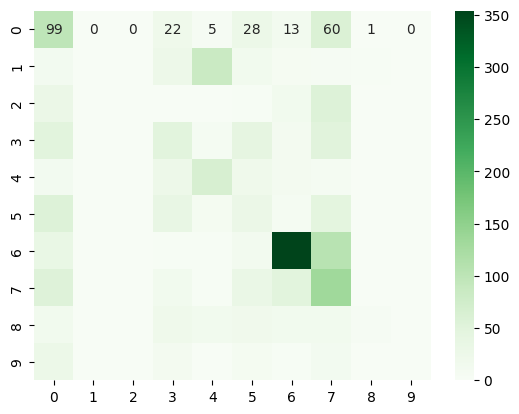

In [48]:
# confusion-matrix visualization
sns.heatmap(cm, annot=True, cmap='Greens')

In [49]:
# get test metrics
preds = model(X_test)
preds = preds.numpy()
preds = preds>0.5
preds=np.argmax(preds, axis=1)
print("Accuracy is", metrics.accuracy_score(y_test, preds))
print("F1 score is", metrics.f1_score(y_test, preds,average='weighted'))
print("Precision is", metrics.precision_score(y_test, preds,average='weighted'))
print("Recall is", metrics.recall_score(y_test, preds,average='weighted'))

Accuracy is 0.324773413897281
F1 score is 0.2771597817615445
Precision is 0.28009770192752037
Recall is 0.324773413897281
